In [1]:
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams["figure.figsize"] = (20,10)

def plot_quantile_compare1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[1]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("t(s)")
    plt.plot(x,y,'.',color='c')
    plt.show()
    
def plot_quantile_compare2(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[2]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("GF/s")
    plt.plot(x,y,'.',color='c')
    #plt.show()
    
    
def plot_quantile_compare_perf1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            time = float(line.split()[1])
            cost = float(line.split()[2])
            y.append((cost/time)*1e-9)
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("GF/s")
    plt.plot(x,y,'.',color='c')
    plt.show()

### Visualizing the dataset

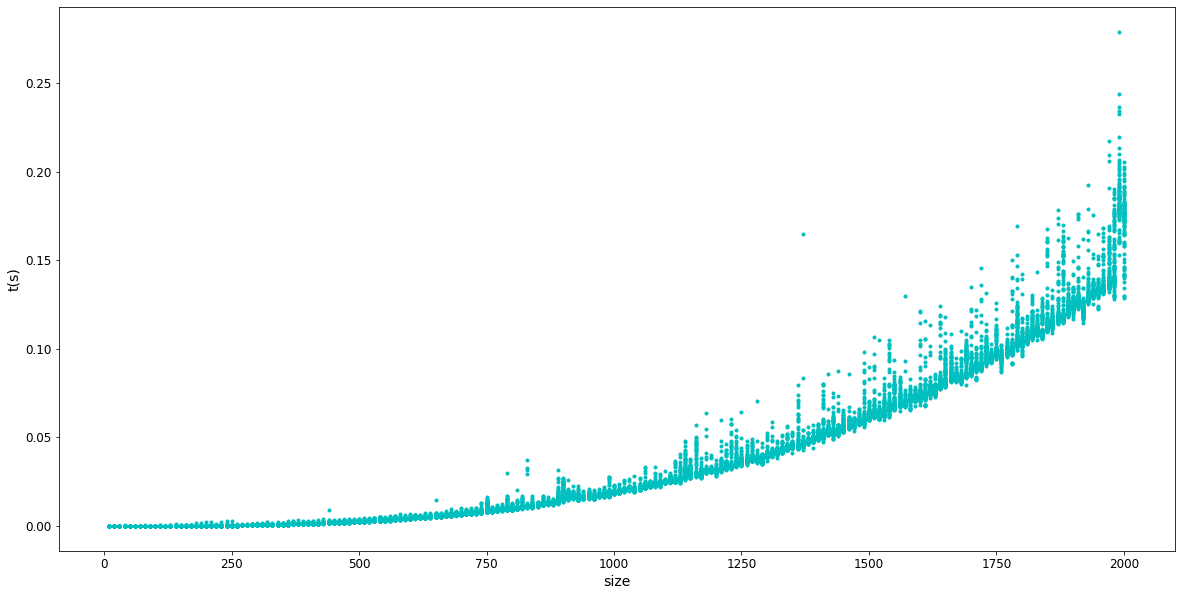

In [5]:
#plt.yscale('log')
plot_quantile_compare1("data/gemm2000.txt")

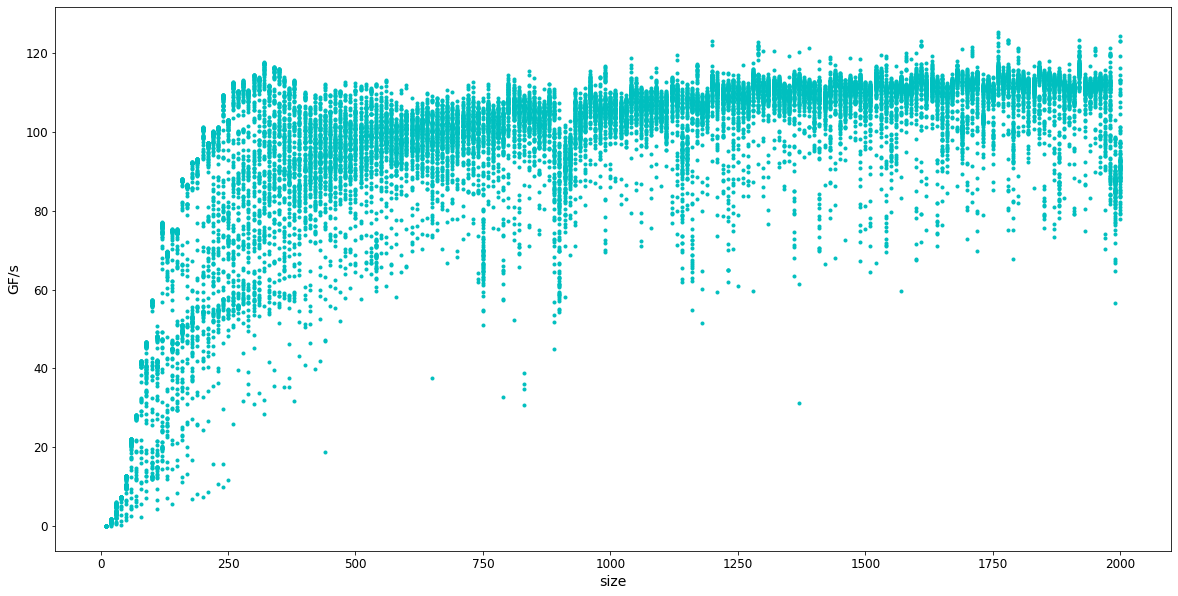

In [6]:
plot_quantile_compare_perf1("data/gemm2000.txt")

### Shuffle dataset

In [65]:
import random

def shuffle_data(log):
    fw = open(log.split(".")[0] + "_shuffled.txt", "w")
    with open(log) as f:
        lines = f.readlines()
        random.shuffle(lines)
        for line in lines:
            fw.write(line)
    fw.close()

In [66]:
shuffle_data("data/gemm2000.txt")

### tf.data API

In [7]:
def cast_to_number(x):
    return tf.strings.to_number(x,out_type=tf.float64)

def split_features_labels(x):
    nn_input = x[0]
    nn_gt = x[2]
    return (nn_input[...,tf.newaxis], nn_gt[...,tf.newaxis])

In [8]:
#filename = "data/gemm2000_shuffled.txt"
filename = "data/gemm2000_shuffled_timeperf_std.txt"
ds_file = tf.data.TextLineDataset(filename)
ds_file = ds_file.map(tf.strings.split)
ds_file = ds_file.map(cast_to_number)
ds_file = ds_file.map(split_features_labels)

### Splitting dataset

In [9]:
DATASET_SIZE = len(open(filename).readlines())

In [10]:
DATASET_SIZE

20000

In [11]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.10 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

train_dataset = ds_file.take(train_size)
test_dataset = ds_file.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

**Iterator**

In [12]:
train_dataset = train_dataset.batch(5)
it = iter(train_dataset)

**Sample point**

In [13]:
x = next(it)
x

(<tf.Tensor: id=120, shape=(5, 1), dtype=float64, numpy=
 array([[1370.],
        [ 580.],
        [ 970.],
        [1550.],
        [1620.]])>, <tf.Tensor: id=121, shape=(5, 1), dtype=float64, numpy=
 array([[0.46376611],
        [0.00382433],
        [0.34930906],
        [0.54793242],
        [0.60669791]])>)

### Neural Network

>$f = W_2\phi(W_1x)$

In [209]:
tf.keras.backend.set_floatx('float64')

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00), input_shape=(None,))
    self.d2 = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d3 = tf.keras.layers.Dense(64, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d4 = tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return self.d4(x)

# Create an instance of the model
model = MyModel()

In [78]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [79]:
input_x, gt_y = next(it)

In [80]:
with tf.GradientTape() as tape:
    nn_out = model(input_x)
    loss_out = loss(gt_y, nn_out) 
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [81]:
input_x, gt_y, nn_out, loss_out

(<tf.Tensor: id=58961, shape=(5, 1), dtype=float64, numpy=
 array([[ 260.],
        [1730.],
        [1650.],
        [  20.],
        [ 760.]])>, <tf.Tensor: id=58962, shape=(5, 1), dtype=float64, numpy=
 array([[3.136000e+00],
        [1.105282e+03],
        [7.920530e+02],
        [1.290000e-01],
        [8.554800e+01]])>, <tf.Tensor: id=59043, shape=(5, 1), dtype=float64, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])>, <tf.Tensor: id=59065, shape=(), dtype=float64, numpy=371264.90625>)

In [175]:
len(gradients) ## W!, B1, W2, B2

4

In [32]:
test_dataset = test_dataset.batch(1)
it_test = iter(test_dataset)

In [33]:
a,b = next(it_test)

In [34]:
a

<tf.Tensor: id=12432, shape=(1, 2), dtype=float64, numpy=array([[1.2400e+03, 1.5376e+06]])>

In [35]:
nn_out = model(a)

In [36]:
nn_out

<tf.Tensor: id=12443, shape=(1, 1), dtype=float64, numpy=array([[0.]])>

### Wrap up

In [236]:
@tf.function
def quantile_loss(q,y,f):
    e = (y-f)
    return tf.keras.backend.mean(q*e + tf.keras.backend.clip(-e,tf.keras.backend.epsilon(),np.inf))

In [237]:
QUANTILE = 0.99
model = MyModel()
#loss = tf.keras.losses.MeanAbsoluteError()
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.RMSprop(lr_schedule)
#optimizer = tf.keras.optimizers.Adam()
mean_loss = tf.keras.metrics.Mean(name='mean_loss')

@tf.function
def train_step(x,gt):
    with tf.GradientTape() as tape:
        nn_out = model(x)
        loss_out = quantile_loss(QUANTILE,gt, nn_out) 
        reg_loss = tf.math.add_n(model.losses)
        loss_out = loss_out + reg_loss
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    mean_loss(loss_out)

In [238]:
def train_model():
    i = 0
    for input_x, gt_y in train_dataset:
        i = i+1
        train_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss.result()))
            mean_loss.reset_states()

In [246]:

train_model()

Iter 100, Loss: 0.008701585738580025
Iter 200, Loss: 0.008713161134654646
Iter 300, Loss: 0.010117965913080755
Iter 400, Loss: 0.008902119447842522
Iter 500, Loss: 0.009098170379785357
Iter 600, Loss: 0.009666200911451383
Iter 700, Loss: 0.007994792182963706
Iter 800, Loss: 0.010486470361753318
Iter 900, Loss: 0.008622783959039622
Iter 1000, Loss: 0.009295427260299858
Iter 1100, Loss: 0.009537157888086312
Iter 1200, Loss: 0.009145160414638271
Iter 1300, Loss: 0.008622221020149728
Iter 1400, Loss: 0.00880707472498452
Iter 1500, Loss: 0.008960247866118374
Iter 1600, Loss: 0.008148140504819877
Iter 1700, Loss: 0.008898276597939484
Iter 1800, Loss: 0.008168787049947905
Iter 1900, Loss: 0.008636470141292908
Iter 2000, Loss: 0.008245651649458102
Iter 2100, Loss: 0.008362611591424412
Iter 2200, Loss: 0.00896040948497427
Iter 2300, Loss: 0.00934244074752611
Iter 2400, Loss: 0.009282615158827008
Iter 2500, Loss: 0.008281215521074293
Iter 2600, Loss: 0.008405295623695663
Iter 2700, Loss: 0.00894

In [29]:
mean_loss_test = tf.keras.metrics.Mean(name='mean_loss_test')

@tf.function
def test_step(x, gt):
    nn_out = model(x)
    test_loss = quantile_loss(QUANTILE,gt, nn_out)

    mean_loss_test(test_loss)
    
    return nn_out

In [30]:
def test_model():
    i = 0
    for input_x, gt_y in test_dataset:
        i = i+1
        result = test_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss_test.result()))
            print(input_x.numpy(), result.numpy(), gt_y.numpy())
        mean_loss_test.reset_states()

In [37]:
test_model()

Iter 100, Loss: 119.79499816894531
[[   830. 688900.]] [[0.]] [[119.795]]
Iter 200, Loss: 340.4159851074219
[[1.2200e+03 1.4884e+06]] [[0.]] [[340.416]]
Iter 300, Loss: 61.887001037597656
[[   680. 462400.]] [[0.]] [[61.887]]
Iter 400, Loss: 42.472999572753906
[[   590. 348100.]] [[0.]] [[42.473]]
Iter 500, Loss: 84.2249984741211
[[   760. 577600.]] [[0.]] [[84.225]]
Iter 600, Loss: 732.8790283203125
[[1.5900e+03 2.5281e+06]] [[0.]] [[732.879]]
Iter 700, Loss: 491.5
[[1.4300e+03 2.0449e+06]] [[0.]] [[491.5]]
Iter 800, Loss: 1.2380000352859497
[[  120. 14400.]] [[0.]] [[1.238]]
Iter 900, Loss: 449.5570068359375
[[1.3400e+03 1.7956e+06]] [[0.]] [[449.557]]
Iter 1000, Loss: 167.1580047607422
[[   990. 980100.]] [[0.]] [[167.158]]
Iter 1100, Loss: 409.7349853515625
[[1.30e+03 1.69e+06]] [[0.]] [[409.735]]
Iter 1200, Loss: 641.7940063476562
[[1.2500e+03 1.5625e+06]] [[0.]] [[641.794]]
Iter 1300, Loss: 1129.0419921875
[[1.8300e+03 3.3489e+06]] [[0.]] [[1129.042]]
Iter 1400, Loss: 252.1990051

### Eval

In [232]:
def get_quantile_gt(filename,quantile):
    data = {}
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            try:
                data[float(line.split()[0])].append(float(line.split()[2]))
            except KeyError:
                data[float(line.split()[0])] = []
                data[float(line.split()[0])].append(float(line.split()[2]))

    for k,v in data.items():
        v.sort()
        
    x_q = []
    y_q = []
    q = int(quantile*100)
    for k,v in data.items():
        x_q.append(k)
        y_q.append(v[q])
        
    return (x_q,y_q)

In [240]:
x_q, y_q = get_quantile_gt(filename,QUANTILE)

In [117]:
eval_size = 250
inp = tf.constant(eval_size,shape=(1,1),dtype="float64")
out = model(inp)

In [118]:
out

<tf.Tensor: id=171826, shape=(1, 1), dtype=float64, numpy=array([[-1.46018609]])>

In [21]:
import numpy as np

In [22]:
sizes = np.arange(10,2110,5)

In [247]:
y = []
for s in sizes:
    inp = tf.constant(s,shape=(1,1),dtype="float64")
    y.append((model(inp).numpy().reshape(-1)))

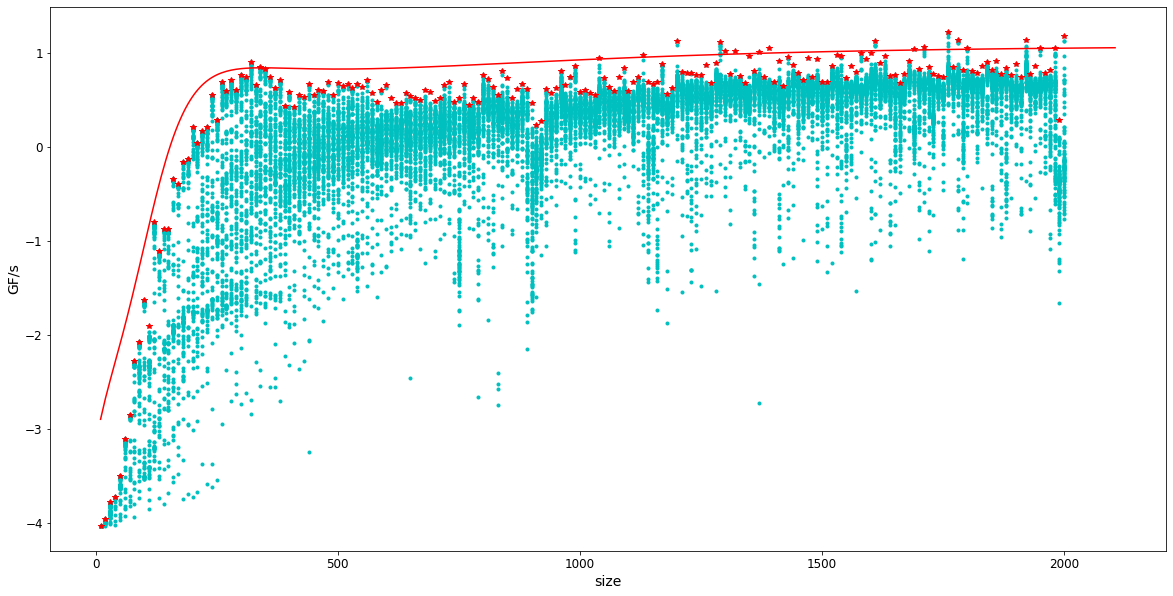

In [248]:
#plt.yscale('log')
plot_quantile_compare2("data/gemm2000_shuffled_timeperf_std.txt")
plt.plot(sizes,y,color='r')
plt.plot(x_q,y_q,'*',color='r')
plt.show()

In [61]:
model.losses

[<tf.Tensor: id=76714, shape=(), dtype=float64, numpy=0.0014421830303465472>,
 <tf.Tensor: id=76722, shape=(), dtype=float64, numpy=0.08558598350079252>,
 <tf.Tensor: id=76730, shape=(), dtype=float64, numpy=0.013166614328004722>]

In [60]:
model.d1.get_weights()

[array([[ 0.0391185 ,  0.07489408,  0.00955415,  0.04121713,  0.04902671,
         -0.01903614, -0.08652303,  0.03212332, -0.00156229, -0.04064424,
          0.00134866,  0.04788559, -0.07253152,  0.01191795,  0.05095224,
          0.09170064,  0.02336713, -0.03497435, -0.00143155,  0.09374009,
         -0.08130883,  0.06990394,  0.02351211, -0.07315359, -0.0200955 ,
          0.00356623,  0.05524848,  0.06423154,  0.00475602, -0.00169657,
          0.07638708,  0.00564956,  0.00153587,  0.01357016, -0.02123212,
          0.05343552,  0.00193306, -0.07996823,  0.01466364, -0.0113572 ,
         -0.04066657, -0.05863961,  0.0525175 , -0.07724095,  0.00845512,
          0.03498058, -0.02012329,  0.00894144,  0.03105336,  0.01251317,
         -0.05991903, -0.08503895,  0.03353598, -0.00361193, -0.00581489,
         -0.00597891,  0.01354368, -0.08245462, -0.01878637,  0.05864049,
          0.08582565,  0.0699049 , -0.01303581,  0.00462505]]),
 array([-0.06335281,  0.05748295,  0.07319406,  

In [64]:
filename

'data/gemm2000_shuffled_timeperf_std.txt'